In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as opt

In [2]:
class Leaf:
    def __init__(self,value):
        self.value = value

In [3]:
class Node:
    def __init__(self,branches,attribute,threshold):
        self.branches = branches
        self.threshold = threshold
        self.attribute = attribute
        
    def get(self,df):
        return self.branches[0] if df[self.attribute] < self.threshold else self.branches[1]
        

In [4]:
class Tree:
    def __init__(self,root):
        self.root = root
        
    def predict(self,x):
        item = self.root
        while isinstance(item,Node):
            item = item.get(x)
        return item

In [5]:
r=Node([Leaf('young'),Leaf('old')],"age",18)
t=Tree(r)
print(t.predict({"age":2}).value)

young


In [6]:
print(t.predict({"age":20}).value)

old


In [7]:
class CART:
    def __init__(self,df,y_name,X_names):
        self.df = df
        self.y_name = y_name
        self.X_names = X_names
        self.tree = None
        self.splittyness = 1.
        self.leaf_loss_threshold = 1e-12
        
        self.classes = np.unique(df[self.y_name]).tolist()
        n = len(self.classes)
        self.confusion_matrix = np.zeros((n,n))
        
    def create_tree(self,splittyness=1., leaf_loss_threshold=1e-12):
        self.splittyness = splittyness
        self.leaf_loss_threshold = leaf_loss_threshold
        root = self._node_or_leaf(self.df)
        self.tree = Tree(root)
        return self.tree
    
    def _gini_impurity(self, df):
        unique, counts = np.unique(df[self.y_name].values, return_counts=True)
        N = df[self.y_name].values.ravel().size
        p = counts/N
        #print(unique)
        #print(p)
        return 1. - np.sum(p**2)
    
    def _opt_fun(self,df,split_name):
        def fun(x):
            split_df = [df[df[split_name]<x],
                        df[df[split_name]>=x]]
            return self._loss(split_df[0]) + self._loss(split_df[1])
        return fun
        
    def _node_or_leaf(self,df):
        loss_parent = self._loss(df)
        if loss_parent < self.leaf_loss_threshold:
            return self._leaf(df)
        
        loss_best, split_df, split_threshold, split_name = self._loss_best(df)
        print(f"Computed split:\nloss: {loss_best:.2f} (parent: {loss_parent:.2f})\nattribute: {split_name}\nthreshold: {split_threshold}\ncount: {[len(df_.index) for df_ in split_df]}")
        if loss_best * self.splittyness < loss_parent:
            print(f"  => creating Node({split_name}, {split_threshold})\n")
            branches = []
            for i in range(2):
                branches.append(self._node_or_leaf(split_df[i]))
            item = Node(branches,split_name,split_threshold)
        else:
            item = self._leaf(df)
        return item
    
    def _leaf(self,df):
        unique, counts = np.unique(df[self.y_name].values,return_counts=True)
        print([(unique[i], counts[i]) for i in range(len(counts))])
        sort_ind = np.argsort(-counts)
        value = unique[sort_ind[0]]
        leaf = Leaf(value)
        
        # confusion matrix
        i_predict = self.classes.index(value)
        for i, c in enumerate(unique):
            i_c = self.classes.index(c)
            self.confusion_matrix[i_c,i_predict] += counts[i]
        
        print(f"  => creating Leaf({value}, N={len(df.index)})\n")
        return leaf
    
    def _loss_best(self,df):
        loss0 = 10
        for name in self.X_names:
            #split_threshold_ = np.median(df[name].v
            res = opt.minimize_scalar(self._opt_fun(df,name),bounds=(df[name].min(),df[name].max()),method="bounded")
            split_threshold_ = res.x
            split_df_ = [df[df[name]<split_threshold_],
                        df[df[name]>=split_threshold_]]
            #loss = self._loss(split_df_[0]) + self._loss(split_df_[1])
            loss = res.fun
            if loss < loss0:
                loss0 = loss
                split_threshold = split_threshold_
                split_df = split_df_
                split_name = name
                
        #print(loss0)
                
        return loss0, split_df, split_threshold, split_name
    
    def _loss(self,df):
        return self._gini_impurity(df)
    
    def metrics(self):
        P = self._precision(self.confusion_matrix)
        print(f"precision: {P}")
        R = self._recall(self.confusion_matrix)
        print(f"recall: {R}")
        F = np.mean(self._F1(P,R))
        print(f"F-score: {F}")
        return {"precision":P,
                "recall":R,
                "F-score":F}
    
    @staticmethod
    def _precision(m):
        return np.diag(m) / np.sum(m, axis=1)
        
    
    @staticmethod
    def _recall(m):
        return np.diag(m) / np.sum(m, axis=0)
    
    @staticmethod
    def _F1(P,R):
        #F = np.zeros_like(P)
        #for i in range(len(
        return 2 * P * R / (P + R)
            
        
        

In [8]:
df=pd.read_csv("iris.csv")

In [9]:
df.columns
X_names=["petal_length","petal_width"]
df[X_names]

,petal_length,petal_width
0,1.4,0.2
1,1.4,0.2
2,1.3,0.2
3,1.5,0.2
4,1.4,0.2
...,...,...
145,5.2,2.3
146,5.0,1.9
147,5.2,2.0
148,5.4,2.3


In [10]:
df.iloc[0]

sepal_length       5.1
sepal_width        3.5
petal_length       1.4
petal_width        0.2
species         setosa
Name: 0, dtype: object

In [11]:
c = CART(df,"species",X_names)
c.create_tree(splittyness=1.)

Computed split:
loss: 0.50 (parent: 0.67)
attribute: petal_length
threshold: 2.3928050106119554
count: [50, 100]
  => creating Node(petal_length, 2.3928050106119554)

[('setosa', 50)]
  => creating Leaf(setosa, N=50)

Computed split:
loss: 0.21 (parent: 0.50)
attribute: petal_width
threshold: 1.7120403835448885
count: [54, 46]
  => creating Node(petal_width, 1.7120403835448885)

Computed split:
loss: 0.18 (parent: 0.17)
attribute: petal_length
threshold: 3.3094496107966327
count: [3, 51]
[('versicolor', 49), ('virginica', 5)]
  => creating Leaf(versicolor, N=54)

Computed split:
loss: 0.05 (parent: 0.04)
attribute: petal_length
threshold: 6.404263506154478
count: [42, 4]
[('versicolor', 1), ('virginica', 45)]
  => creating Leaf(virginica, N=46)



In [12]:
c.tree.predict(df.iloc[0]).value

'setosa'

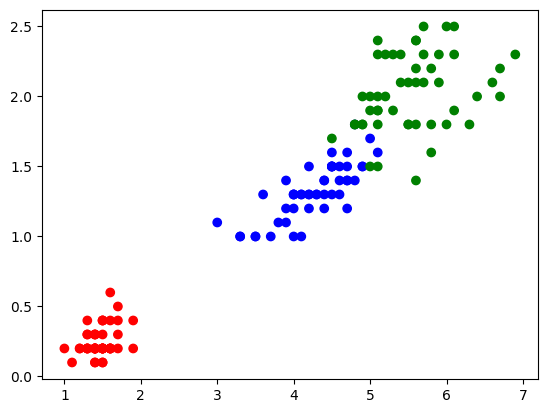

In [13]:
import matplotlib.pyplot as plt
colors = {"setosa":"red", "versicolor":"blue", "virginica":"green"}
plt.scatter(df["petal_length"],df["petal_width"],c=df["species"].map(colors))


In [14]:

x, y = np.meshgrid(np.linspace(1,7,11),np.linspace(0,2.5,11))
col = []
for i in range(len(x.ravel())):
    d = df.iloc[120].copy()
    d["petal_length"] = x.ravel()[i]
    d["petal_width"] = y.ravel()[i]
    col.append(c.tree.predict(d).value)
for i in range(len(col)):
    if col[i] == "setosa":
        col[i] = 0
    if col[i] == "versicolor":
        col[i] = 1
    if col[i] == "virginica":
        col[i] = 2
z = np.array(col).reshape(x.shape)

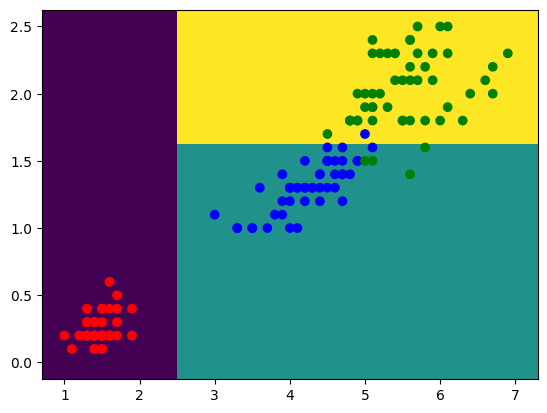

In [15]:
fig, ax = plt.subplots()
ax.pcolormesh(x,y,z)
ax.scatter(df["petal_length"],df["petal_width"],c=df["species"].map(colors))

In [16]:
c.confusion_matrix
c.metrics()

precision: [1.   0.98 0.9 ]
recall: [1.         0.90740741 0.97826087]
F-score: 0.9599358974358975


{'precision': array([1.  , 0.98, 0.9 ]),
 'recall': array([1.        , 0.90740741, 0.97826087]),
 'F-score': 0.9599358974358975}